In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! cd /content/drive/MyDrive/hw/data/video-features && ls

12mo-baby.pkl  6mo-baby.pkl  all_audio-2.npy  all_mom-2.npy  clean_audio.pkl
12mo-mom.pkl   6mo-mom.pkl   all_baby-2.npy   all_y.npy      mental_health.csv


In [166]:
import pandas as pd
import numpy as np
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, BatchNormalization, GRU, Activation, LSTM
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(42)

In [4]:
DATA_DIR = "/content/drive/MyDrive/hw/data/video-features"
Y_data = "mental_health.csv"
mom_12 = "12mo-mom.pkl"
mom_6 = "6mo-mom.pkl"
baby_12 = "12mo-baby.pkl"
baby_6 = "6mo-baby.pkl"
audio = "clean_audio.pkl"



In [ ]:
# dtypes = list(zip(dataframe.dtypes.index, map(str, dataframe.dtypes)))
#     # Normalize numeric columns.
#     for column, dtype in dtypes:
#         if dtype == 'float32':
#             dataframe[column] -= dataframe[column].mean()
#             dataframe[column] /= dataframe[column].std()

In [5]:
def load_data(file):
  with open(DATA_DIR+"/"+file, "rb") as f:
    return pickle.load(f)

In [6]:
mom_12 = load_data(mom_12)
mom_6 = load_data(mom_6)
baby_12 = load_data(baby_12)
baby_6 = load_data(baby_6)
all_audio = load_data(audio)

In [7]:
all_y = pd.read_csv(DATA_DIR+"/"+Y_data)

In [8]:
print(len(baby_12) + len(baby_6))

257


In [9]:
print(len(mom_12) + len(mom_6))

243


In [10]:
audio_data_12 = all_audio[all_audio['month'] == '12']
audio_data_6 = all_audio[all_audio['month'] == '6']

In [11]:
print(len(audio_data_12),len(audio_data_6))

124 142


In [12]:
def filter_data(mom_df, baby_df):
  # Identify IDs unique to mom and baby
  mom_unique_ids = set(mom_df['id']) - set(baby_df['id'])
  baby_unique_ids = set(baby_df['id']) - set(mom_df['id'])

  # Drop rows with unique IDs from mom and baby
  mom_filtered = mom_df[~mom_df['id'].isin(mom_unique_ids)]
  baby_filtered = baby_df[~baby_df['id'].isin(baby_unique_ids)]
  return mom_filtered, baby_filtered

In [13]:
def filter_data_audio(mom_df, audio_df):
  # Identify IDs unique to mom and baby
  mom_unique_ids = set(mom_df['id']) - set(audio_df['mom_id'])
  baby_unique_ids = set(audio_df['mom_id']) - set(mom_df['id'])

  # Drop rows with unique IDs from mom and baby
  mom_filtered = mom_df[~mom_df['id'].isin(mom_unique_ids)]
  baby_filtered = audio_df[~audio_df['mom_id'].isin(baby_unique_ids)]
  return mom_filtered, baby_filtered

In [14]:
mom_12, baby_12 = filter_data(mom_12, baby_12)
mom_6, baby_6 = filter_data(mom_6, baby_6)

In [15]:
print(len(mom_12) + len(mom_6))
print(len(baby_12) + len(baby_6))

239
240


In [16]:
unique_ids =  set(audio_data_12['mom_id']) - set(mom_12['id'])
unique_ids
audio_data_12 = audio_data_12[~audio_data_12['mom_id'].isin(unique_ids)]

In [17]:
unique_ids =  set(audio_data_6['mom_id']) - set(mom_6['id'])
unique_ids
audio_data_6 = audio_data_6[~audio_data_6['mom_id'].isin(unique_ids)]

In [18]:
mom_12, audio_12 = filter_data_audio(mom_12, audio_data_12)
mom_6, audio_6 = filter_data_audio(mom_6, audio_data_6)

In [19]:
print(len(audio_12),len(audio_6))

101 121


In [20]:
mom_12, baby_12 = filter_data(mom_12, baby_12)
mom_6, baby_6 = filter_data(mom_6, baby_6)

In [21]:
print(len(mom_12) + len(mom_6))
print(len(baby_12) + len(baby_6))

220
221


In [22]:
unique_ids =   set(mom_12['id']) - set(audio_data_12['mom_id'])
unique_ids

set()

In [23]:
unique_ids =   set(mom_6['id']) - set(audio_data_6['mom_id'])
unique_ids

set()

In [24]:
baby_12 = baby_12.drop_duplicates(subset='id', keep='first')
audio_12 = audio_12.drop_duplicates(subset='mom_id', keep='first')
audio_6 = audio_6.drop_duplicates(subset='mom_id', keep='first')

In [25]:
# match rows
baby_12 = baby_12.set_index('id').loc[mom_12['id'].tolist()].reset_index()
baby_6 = baby_6.set_index('id').loc[mom_6['id'].tolist()].reset_index()
audio_12 = audio_12.set_index('mom_id').loc[mom_12['id'].tolist()].reset_index()
audio_6 = audio_6.set_index('mom_id').loc[mom_6['id'].tolist()].reset_index()

In [26]:
all_mom = pd.concat([mom_12, mom_6], ignore_index=True)
all_baby = pd.concat([baby_12, baby_6], ignore_index=True)
all_audio = pd.concat([audio_12, audio_6], ignore_index=True)

In [27]:
print(len(all_mom), len(all_baby), len(all_audio))

220 220 220


In [28]:
Y = []
for i in range(len(all_mom)):
  row = all_mom.iloc[i]
  id = row['id']
  month = row['month']
  phq = all_y[(all_y['id'] == id) & (all_y['month'] == month)]['phq']
  phq = phq.values[0]
  if phq <= 4.0:
    Y.append(0)
  elif phq <= 9.0:
    Y.append(1)
  elif phq <= 14.0:
    Y.append(2)
  elif phq <= 19.0:
    Y.append(3)
  else:
    Y.append(4)

In [29]:
Y = np.array(Y)

In [44]:
np.save('all_y.npy', Y)

In [30]:
np.unique(Y, return_counts=True)

(array([0, 1, 2, 3, 4]), array([151,  47,  15,   4,   3]))

In [30]:
all_mom.shape

(220, 14)

In [143]:
all_baby.shape

(220, 14)

In [144]:
all_audio.shape

(220, 7)

In [31]:
def balance_data(X, Y, value, update_Y=False, many=100, noise_mean=0, noise_std=0.1):
    # Get the indices where Y equals the specified value
    X = X.copy()
    Y = Y.copy()
    indices = np.where(Y == value)[0]
    count = 0
    #noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(X.shape[1], X.shape[2]))
    while True:
      # create synthetic data
      for idx in indices:
        duplicated_row = np.expand_dims(X[idx], axis=0)
        X = np.concatenate((X, duplicated_row), axis=0)
        # add gaussian noise to data
        # creates more data and also increases model robustness
        noise = np.random.normal(loc=noise_mean, scale=noise_std, size=(duplicated_row.shape[1], duplicated_row.shape[2]))
        noisy_row = X[-1] + noise
        X[-1] = noisy_row

        # Append the specified value to Y if update_Y is True
        if update_Y:
          Y = np.append(Y, value)

        count += 1
      if count >= many:
        break
    return X, Y

In [57]:
dtypes = list(zip(all_audio.dtypes.index, map(str, all_audio.dtypes)))
dtypes

[('mom_id', 'int64'),
 ('month', 'object'),
 ('total_seconds', 'float64'),
 ('interval_size', 'int64'),
 ('pitches', 'object'),
 ('pitch_ranges', 'object'),
 ('speech_rates', 'object')]

In [95]:
columns = ['AU01_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r', 'AU12_r', 'AU23_r', 'AU25_r', 'AU26_r']

def data_preprocessing(df):
  np_array = np.empty((220, 180, 11))
  for i in range(len(df)):
    row = df.iloc[i]
    dict_row = row.to_dict()
    data_frame = pd.DataFrame(dict_row)
    # drop id, frame and month
    arr = data_frame.filter(columns)
    for column in columns:
      if arr[column].isna().any():
        col_mean = arr[column].mean(skipna=True)
        arr[column].fillna(col_mean, inplace=True)
    scaled_data = arr.values
    # Check if the number of columns after scaling is greater than 180
    if scaled_data.shape[0] > 180:
      scaled_data = scaled_data[:180, :]
    elif scaled_data.shape[0] < 180:
      # Pad data with zeros if less than 180 rows
      pad_width = 180 - scaled_data.shape[0]
      scaled_data = np.pad(scaled_data, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
    np_array[i] = scaled_data
  return np_array

In [53]:
columns_audio = ['pitches', 'pitch_ranges', 'speech_rates']
#columns_audio = ['pitches', 'pitch_ranges']

def data_preprocessing_audio(df):
  np_array = np.empty((220, 180, 3))
  for i in range(len(df)):
    row = df.iloc[i]
    if len(row['speech_rates']) < len(row['pitches']):
      row['speech_rates'].append(0)  # Append a value to match the length of other columns
    dict_row = row.to_dict()
    data_frame = pd.DataFrame(dict_row)
    # drop id, month, total_second, interval_size, and unnamed
    arr = data_frame.filter(columns_audio)
    scaled_data = arr.values
    # Check if the number of columns after scaling is greater than 180
    if scaled_data.shape[0] > 180:
      # crop
      scaled_data = scaled_data[:180, :]
    elif scaled_data.shape[0] < 180:
    # Pad with zeros to achieve 180 columns
      pad_width = 180 - scaled_data.shape[0]
      scaled_data = np.pad(scaled_data, ((0, pad_width), (0, 0)), mode='constant', constant_values=0)
    np_array[i] = scaled_data
  return np_array

In [38]:
data_frame = pd.DataFrame(all_audio.iloc[0].to_dict())
dtypes = list(zip(data_frame.dtypes.index, map(str, data_frame.dtypes)))
dtypes

[('mom_id', 'int64'),
 ('month', 'object'),
 ('total_seconds', 'float64'),
 ('interval_size', 'int64'),
 ('pitches', 'float64'),
 ('pitch_ranges', 'float64'),
 ('speech_rates', 'float64')]

In [117]:
X_mom = data_preprocessing(all_mom)
X_baby = data_preprocessing(all_baby)
X_audio = data_preprocessing_audio(all_audio)

In [53]:
np.save('all_mom.npy', X_mom)
np.save('all_baby.npy', X_baby)
np.save('all_audio.npy', X_audio)

In [118]:
np.any(np.isnan(X_mom))

False

In [119]:
Y.shape

(220,)

In [120]:
X_baby.shape

(220, 180, 11)

In [121]:
X_audio.shape

(220, 180, 3)

In [122]:
X_mom.shape

(220, 180, 11)

In [ ]:
# create synthetic data
new_mom_x, new_y = balance_data(X_mom, Y, 4, update_Y=True, many=150)
new_baby_x, _ = balance_data(X_baby, Y, 4, update_Y=False, many=150)
new_audio_x, _ = balance_data(X_audio, Y, 4, update_Y=False, many=150)

In [126]:
new_mom_x, btw_y = balance_data(new_mom_x, new_y, 3, update_Y=True, many=150)
new_baby_x, _ = balance_data(new_baby_x, new_y, 3, update_Y=False, many=150)
new_audio_x, _ = balance_data(new_audio_x, new_y, 3, update_Y=False, many=150)

In [127]:
new_mom_x, btw2_y = balance_data(new_mom_x, btw_y, 2, update_Y=True, many=130)
new_baby_x, _ = balance_data(new_baby_x, btw_y, 2, update_Y=False, many=130)
new_audio_x, _ = balance_data(new_audio_x, btw_y, 2, update_Y=False, many=130)

In [128]:
new_mom_x, final_y = balance_data(new_mom_x, btw2_y, 1, update_Y=True, many=95)
new_baby_x, _ = balance_data(new_baby_x, btw2_y, 1, update_Y=False, many=95)
new_audio_x, _ = balance_data(new_audio_x, btw2_y, 1, update_Y=False, many=95)

In [129]:
np.any(np.isnan(new_mom_x))

False

In [130]:
final_y.shape

(798,)

In [131]:
new_mom_x.shape

(798, 180, 11)

In [132]:
new_baby_x.shape

(798, 180, 11)

In [133]:
new_audio_x.shape

(798, 180, 3)

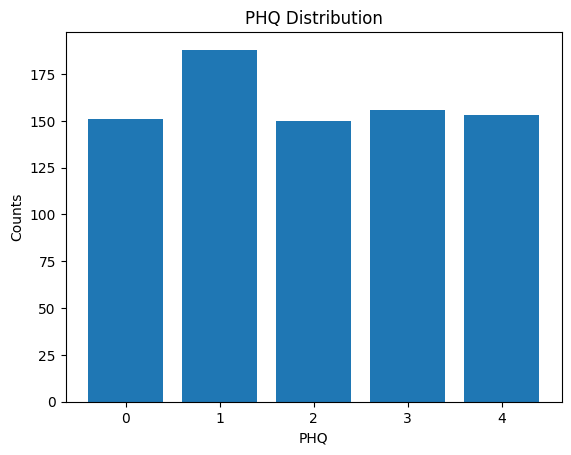

In [193]:
# check label distribution
unique_values, value_counts = np.unique(final_y, return_counts=True)
# Create bar chart
plt.bar(unique_values, value_counts)

# Add labels and title
plt.xlabel('PHQ')
plt.ylabel('Counts')
plt.title('PHQ Distribution')

# Show the plot
plt.show()

In [135]:
# get length of data
length = len(new_mom_x)
original_indices = list(range(length))
# Shuffle the indices
random.shuffle(original_indices)

In [136]:
# shuffle data
X_mom = new_mom_x[original_indices]
X_baby = new_baby_x[original_indices]
X_audio = new_audio_x[original_indices]
Y_array = final_y[original_indices]

In [137]:
def normalize_data(data):
  mean = np.nanmean(data, axis=0)
  std_dev = np.nanstd(data, axis=0)
  normalized_arr = (data - mean) / std_dev
  return normalized_arr

In [ ]:
X_mom = normalize_data(X_mom)
X_baby = normalize_data(X_baby)
X_audio = normalize_data(X_audio)

In [139]:
# save final data
np.save('norm_mom.npy', X_mom)
np.save('norm_baby.npy', X_baby)
np.save('norm_audio.npy', X_audio)
np.save('norm_y.npy', Y_array)

In [138]:
type(X_baby)

numpy.ndarray

In [142]:
# get train index
train_index = int(0.8  * len(X_mom))
train_index

638

In [143]:
train_X_mom = X_mom[:train_index]
train_X_baby = X_baby[:train_index]
train_X_audio = X_audio[:train_index]
train_Y = Y_array[:train_index]

In [169]:
train_X_audio.shape

(638, 180, 3)

In [144]:
# check if nan exist in data
np.any(np.isnan(train_X_mom))

False

In [160]:
def classifier_mental(input_shape=(180, 11), audio_shape=(180, 3), units=500, dropout_rate=0.5, num_classes=5):
    mom_input = Input(shape=input_shape, name='mom_feat')
    baby_input = Input(shape=input_shape, name='baby_feat')
    audio_input = Input(shape=audio_shape, name='audio_feat')

    # Flatten each input
    flat_mom_input = tf.keras.layers.Flatten(name='mom_flat')(mom_input)
    flat_baby_input = tf.keras.layers.Flatten(name='baby_flat')(baby_input)
    flat_audio_input = tf.keras.layers.Flatten(name='audio_flat')(audio_input)

    mom_output = Dense(units=2000, activation='relu', kernel_initializer='he_normal', name='mom_dense_1')(flat_mom_input)
    mom_output = BatchNormalization(name='batch_norm_mom_1')(mom_output)
    mom_output = Dropout(dropout_rate, name='mom_drop_1')(mom_output)

    mom_output = Dense(units=1056, activation='relu', kernel_initializer='he_normal', name='mom_dense_2')(mom_output)
    mom_output = BatchNormalization(name='batch_norm_mom_2')(mom_output)
    mom_output = Dropout(dropout_rate, name='mom_drop_2')(mom_output)


    baby_output = Dense(units=2000, activation='relu', kernel_initializer='he_normal', name='baby_dense_1')(flat_baby_input)
    baby_output = BatchNormalization(name='batch_norm_baby_1')(baby_output)
    baby_output = Dropout(dropout_rate, name='baby_drop_1')(baby_output)

    baby_output = Dense(units=1056, activation='relu', kernel_initializer='he_normal', name='baby_dense_2')(baby_output)
    baby_output = BatchNormalization(name='batch_norm_baby_2')(baby_output)
    baby_output = Dropout(dropout_rate, name='baby_drop_2')(baby_output)

    audio_output = Dense(units=512, activation='relu', kernel_initializer='he_normal', name='audio_dense_1')(flat_audio_input)
    audio_output = BatchNormalization(name='batch_norm_audio_1')(audio_output)
    audio_output = Dropout(dropout_rate, name='audio_drop_1')(audio_output)

    audio_output = Dense(units=256, activation='relu', kernel_initializer='he_normal', name='audio_dense_2')(audio_output)
    audio_output = BatchNormalization(name='batch_norm_audio_2')(audio_output)
    audio_output = Dropout(dropout_rate, name='audio_drop_2')(audio_output)

    concatenated_inputs = concatenate([mom_output, baby_output, audio_output], name='concat_all')

    output = Dense(units=1600, activation='relu', kernel_initializer='he_normal', name='all_dense_1')(concatenated_inputs)
    output = BatchNormalization(name='batch_norm_all_1')(output)
    output = Dropout(dropout_rate, name='drop_all_1')(output)

    output = Dense(units=512, activation='relu', kernel_initializer='he_normal', name='all_dense_2')(output)
    output = BatchNormalization(name='batch_norm_all_2')(output)
    output = Dropout(dropout_rate, name='drop_all_2')(output)

    # Output layer
    output = Dense(units=num_classes, name='pred')(output)

    # Define the model
    model = Model(inputs=[mom_input, baby_input, audio_input], outputs=output)

    return model


In [182]:
model = classifier_mental()
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 mom_feat (InputLayer)       [(None, 180, 11)]            0         []                            
                                                                                                  
 baby_feat (InputLayer)      [(None, 180, 11)]            0         []                            
                                                                                                  
 audio_feat (InputLayer)     [(None, 180, 3)]             0         []                            
                                                                                                  
 mom_flat (Flatten)          (None, 1980)                 0         ['mom_feat[0][0]']            
                                                                                            

In [183]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, metrics=['accuracy'], loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
history = model.fit([train_X_mom, train_X_baby, train_X_audio], train_Y, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 7s 346ms/step - loss: 1.6126 - accuracy: 0.5059 - val_loss: 0.7876 - val_accuracy: 0.7734
Epoch 2/10
8/8 [==============================] - 2s 282ms/step - loss: 0.5766 - accuracy: 0.8000 - val_loss: 0.9886 - val_accuracy: 0.8047
Epoch 3/10
8/8 [==============================] - 3s 387ms/step - loss: 0.2746 - accuracy: 0.9059 - val_loss: 0.5644 - val_accuracy: 0.8672
Epoch 4/10
8/8 [==============================] - 3s 364ms/step - loss: 0.1767 - accuracy: 0.9431 - val_loss: 0.5157 - val_accuracy: 0.9062
Epoch 5/10
8/8 [==============================] - 2s 277ms/step - loss: 0.0784 - accuracy: 0.9667 - val_loss: 0.4049 - val_accuracy: 0.9453
Epoch 6/10
8/8 [==============================] - 2s 277ms/step - loss: 0.0713 - accuracy: 0.9745 - val_loss: 0.3102 - val_accuracy: 0.9219
Epoch 7/10
8/8 [==============================] - 2s 282ms/step - loss: 0.0641 - accuracy: 0.9843 - val_loss: 0.3446 - val_accuracy: 0.9375
Epoch 8/10
8/8 [====

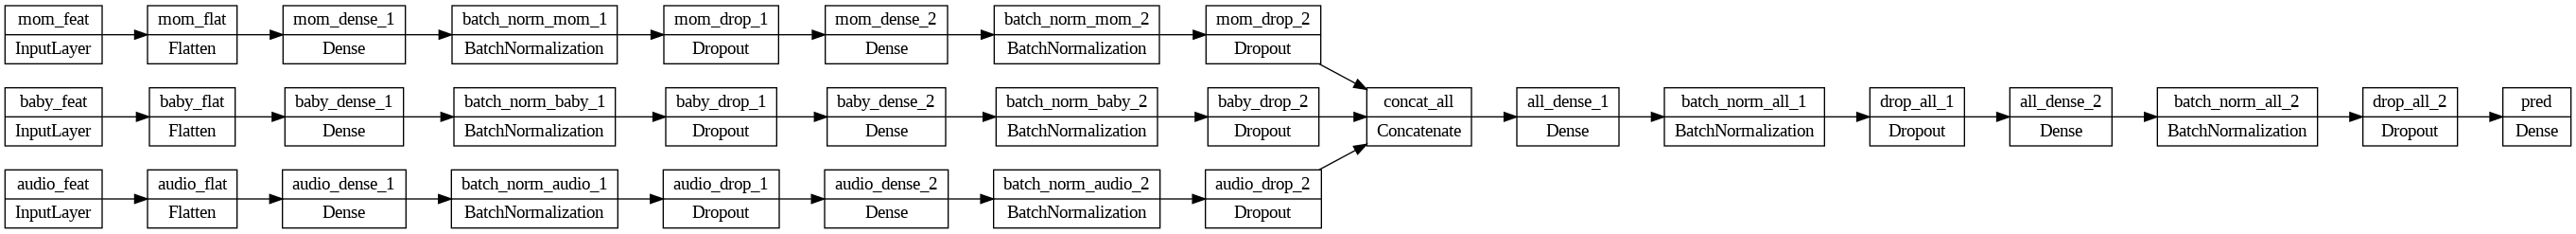

In [174]:
tf.keras.utils.plot_model(model, 'mental_pred.png', show_shapes=False, rankdir='LR')

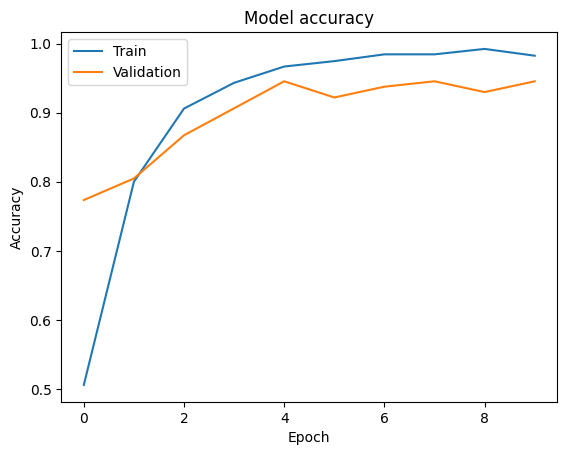

In [184]:
# check for overfitting
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [148]:
test_X_mom = X_mom[train_index:]
test_X_baby = X_baby[train_index:]
test_X_audio = X_audio[train_index:]
test_Y = Y_array[train_index:]

In [185]:
loss, accuracy = model.evaluate([test_X_mom, test_X_baby, test_X_audio], test_Y)

5/5 [==============================] - 1s 60ms/step - loss: 0.2687 - accuracy: 0.9625


In [186]:
y_pred = model.predict([test_X_mom, test_X_baby, test_X_audio])

5/5 [==============================] - 0s 35ms/step


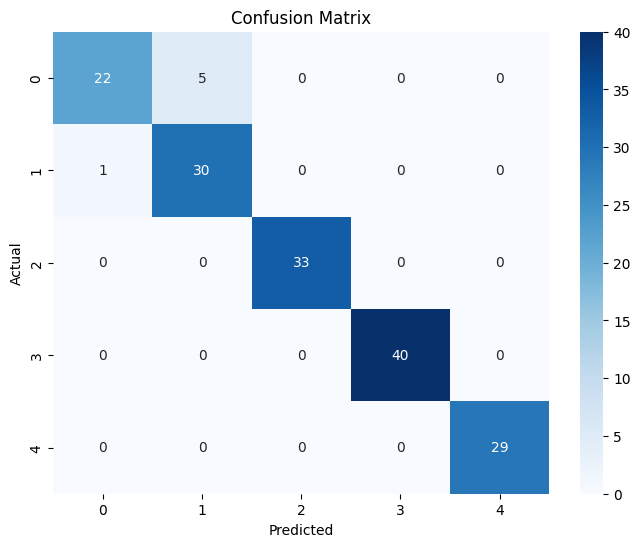

In [187]:
cm = confusion_matrix(test_Y, np.argmax(y_pred, axis=1))
# plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [189]:
# save model
model.save('mental_pred_final')

In [190]:
! tar -czvf mental_pred_final.tar.gz mental_pred_final

mental_pred_final/
mental_pred_final/assets/
mental_pred_final/variables/
mental_pred_final/variables/variables.data-00000-of-00001
mental_pred_final/variables/variables.index
mental_pred_final/saved_model.pb
mental_pred_final/fingerprint.pb
mental_pred_final/keras_metadata.pb
